In [22]:
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [24]:
class Conf:
    def __init__(self):
        self.batch_size = 64
        self.num_classes = 10
        self.len_nz = 100
        self.learning_rate = 0.001
        self.epochs = 10
        self.img_size = 32
        self.loss_adversarial = torch.nn.BCELoss()
        self.loss_classification = torch.nn.CrossEntropyLoss()
        self.optimizerG = 'Adam'
        self.optimizerD = 'Adam'


In [25]:
conf = Conf()

In [26]:

# If you want to resize the images to a different resolution, change the value here
# For CIFAR-10, the original resolution is 32x32


transform = transforms.Compose([
    # [transforms.Resize((conf.img_size, conf.img_size)),  # Resize the image
     transforms.ToTensor(),  # Convert the image to a tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=conf.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=conf.batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


tensor(0.8667) tensor(-1.)


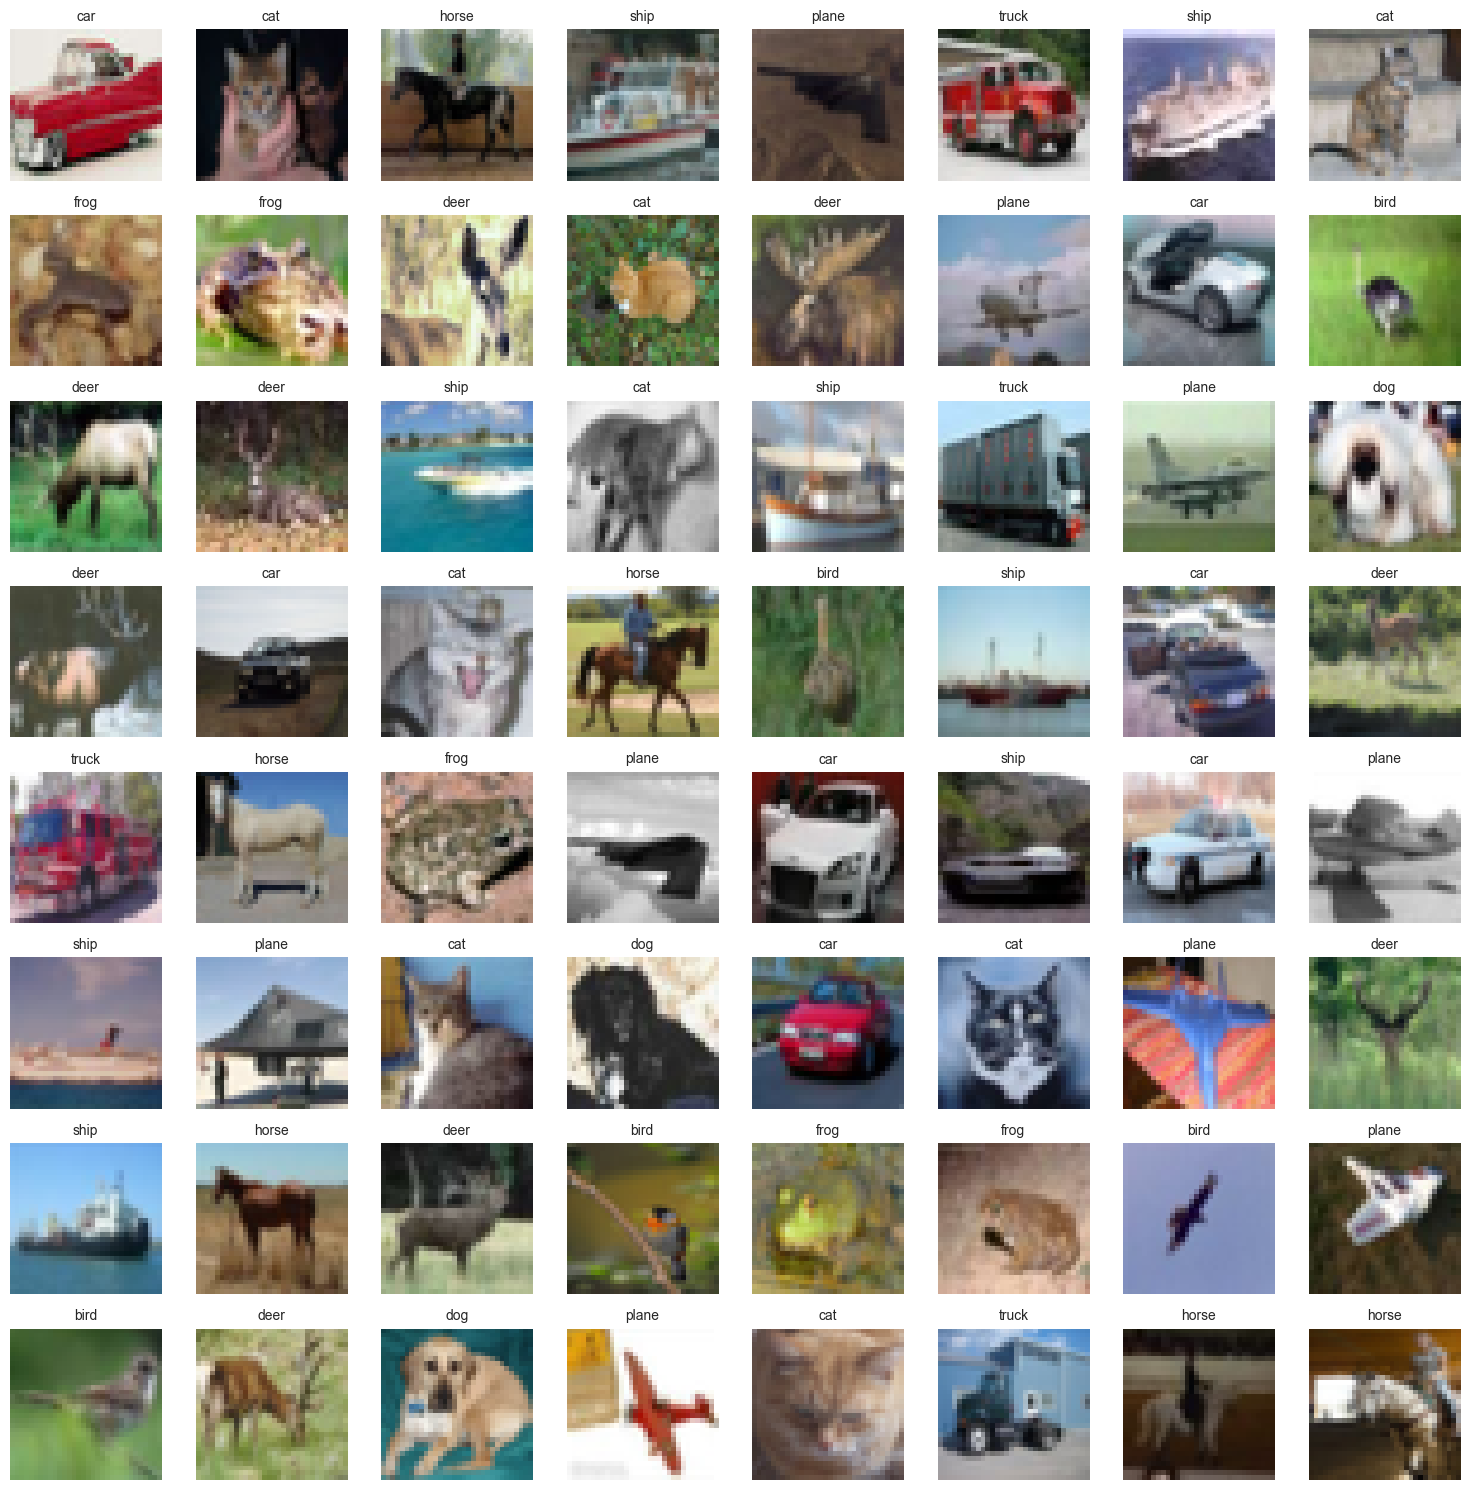

In [27]:

plt.figure(figsize=(15,15))
num_images = 64
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images[2].max(), images[2].min())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for idx in range(num_images):
    ax = plt.subplot(8, 8, idx + 1) # Arrange subplots in a 10x10 grid
    plt.imshow(np.transpose((images[idx].numpy() + 1) / 2, (1, 2, 0)))
    ax.set_title(classes[labels[idx]], fontsize=10) # Set title to the class of the image
    plt.axis('off')
plt.tight_layout()
plt.show()


In [28]:
# class Generator(nn.Module):
#     def __init__(self, nz, num_classes, img_size):
#         super(Generator, self).__init__()
#         self.nz = nz
#         self.num_classes = num_classes
#         self.img_size = img_size
#         self.label_emb = nn.Embedding(num_classes, nz)
#         self.init_size = img_size // 4
#         self.l1 = nn.Linear(nz * 2, 128 * self.init_size ** 2)
#
#         self.conv_blocks = nn.Sequential(
#             nn.BatchNorm2d(128),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(128, 128, 3, stride=1, padding=1),
#             nn.BatchNorm2d(128, 0.8),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(128, 64, 3, stride=1, padding=1),
#             nn.BatchNorm2d(64, 0.8),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(64, 3, 3, stride=1, padding=1),
#             nn.Tanh(),
#         )
#
#     def forward(self, noise, labels):
#         gen_input = torch.cat((self.label_emb(labels), noise), dim=1)
#         # print(gen_input.shape)
#         out = self.l1(gen_input)
#         out = out.view(out.shape[0], 128, self.init_size, self.init_size)
#         img = self.conv_blocks(out)
#         return img

# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.label_emb = nn.Embedding(conf.num_classes, conf.len_nz)
#         self.main = nn.Sequential(
#             nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(512),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(256),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # nn.Sigmoid()
#         )
#
#     def forward(self, noise, labels):
#         # input = torch.cat((self.label_emb(labels), noise), dim=1)
#         input = torch.mul(self.label_emb(labels), noise)
#         input = input.view(input.shape[0], -1, 1, 1)
#         output = self.main(input)
#         # print(output.shape)
#         return output


# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             nn.Conv2d(3, 64, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(64, 128, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(128, 256, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),
#
#         )
#         self.img_real = nn.Sequential(
#             nn.Conv2d(256, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )
#         self.classification = nn.Sequential(
#             nn.Linear(256*4*4, 256),
#             nn.Linear(256, conf.num_classes)
#         )
#
#     def forward(self, input):
#         output = self.main(input)
#         # print(output.shape)
#         img_real = self.img_real(output).view(-1)
#         classification = self.classification(output.view(input.shape[0], -1)).squeeze()
#         # print(classification.shape)
#         # print(input.shape)
#         return img_real, classification

In [29]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(conf.num_classes, conf.len_nz)
        self.main = nn.Sequential(
            # This layer's configuration should be set to match the first layer of the generator G(z)
            nn.ConvTranspose2d(conf.len_nz, 384, 4, 1, 0, bias=False),
            nn.ReLU(True),
            # Subsequent layers follow the pattern from the table
            nn.ConvTranspose2d(384, 192, 4, 2, 1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
            nn.ConvTranspose2d(192, 96, 4, 2, 1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(True),
            nn.ConvTranspose2d(96, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # input = torch.cat(self.label_emb(labels), noise)
        input = torch.cat(labels, noise)
        print(input.shape)
        input = input.view(input.shape[0], -1, 1, 1)
        output = self.main(input)
        print(output.shape)
        return output

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        # The output of the final conv layer will be 512 * 4 * 4, given the input size and the layer parameters.
        self.img_to_features = nn.Sequential(
            nn.Linear(512 * 4 * 4, 256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.classification = nn.Linear(256, 11)

    def forward(self, input):
        print('D', input.shape)
        output = self.main(input)
        print('D', output.shape)
        img_real = output.view(-1)
        print('D', img_real.shape)
        features = self.img_to_features(output.view(input.shape[0], -1))
        print('D', features.shape)
        classification = self.classification(features)
        print('D', classification.shape)
        return

In [30]:
# Parameters


# Initialize Generator and Discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)
# netD = Discriminator(conf.num_classes, 3).to(device)


In [31]:


def training_loop(netG, netD, epochs=conf.epochs):
    netG.train()
    netD.train()
    lossesG = []
    lossesD = []
    loss_adversarial = conf.loss_adversarial
    loss_classification = conf.loss_classification

    if conf.optimizerG == 'Adam':
        optimizerG = optim.Adam(netG.parameters(), lr=conf.learning_rate)
    else:
        optimizerG = optim.Adam(netG.parameters(), lr=conf.learning_rate)
    if conf.optimizerD == 'Adam':
        optimizerD = optim.Adam(netD.parameters(), lr=conf.learning_rate)
    else:
        optimizerD = optim.Adam(netD.parameters(), lr=conf.learning_rate)
    # schedulerG = lr_scheduler.ReduceLROnPlateau(optimizerG, factor=0.3, patience=5)  # Adjust parameters as needed
    # schedulerD = lr_scheduler.ReduceLROnPlateau(optimizerD, factor=0.3, patience=5)
    for epoch in range(epochs):
        for i, (real_images, labels) in enumerate(train_loader):
            # ---------------------
            # Train Discriminator
            # ---------------------
            netD.zero_grad()
            real_images = real_images.to(device)
            labels = labels.to(device)
            batch_size = real_images.shape[0]
            # Real images
            real_output, real_class_output = netD(real_images)  # Get source and class outputs
            # print(real_output.shape)
            real_source_label = torch.ones(batch_size, device=device)  # Real source label
            real_source_loss = loss_adversarial(real_output, real_source_label)
            real_class_loss = loss_classification(real_class_output, labels)

            # Fake images
            noise = torch.randn(batch_size, conf.len_nz, device=device)
            # print(noise.shape)
            fake_labels = torch.randint(0, conf.num_classes, (batch_size,), device=device)  # Random class labels
            fake_images = netG(noise, fake_labels)
            fake_output, fake_class_output = netD(fake_images.detach())  # Get source and class outputs
            fake_source_label = torch.zeros(batch_size, device=device)  # Fake source label
            fake_source_loss = loss_adversarial(fake_output, fake_source_label)
            fake_class_loss = loss_classification(fake_class_output, fake_labels)

            # Combine losses and update discriminator
            lossD = real_source_loss  + fake_source_loss + real_class_loss # + fake_class_loss
            lossD.backward()
            optimizerD.step()

            # ---------------------
            # Train Generator
            # ---------------------
            netG.zero_grad()

            # Generate fake images and labels
            noise = torch.randn(batch_size, conf.len_nz, device=device)
            fake_labels = torch.randint(0, conf.num_classes, (batch_size,), device=device)
            fake_images = netG(noise, fake_labels)

            # Discriminator output and target labels
            fake_output, fake_class_output = netD(fake_images)  # Get source and class outputs
            # real_source_label = torch.ones(batch_size, 1, device=device)  # Target real source label
            fake_source_loss = loss_adversarial(fake_output, real_source_label)
            fake_class_loss = loss_classification(fake_class_output, fake_labels)
            # Generator loss
            lossG = fake_source_loss + fake_class_loss
            # schedulerG.step(lossD)
            # schedulerD.step(lossG)
            # Update generator
            lossG.backward()
            optimizerG.step()
            lossesG.append(lossG)
            lossesD.append(lossD)
            if i % 100 == 0:
                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(train_loader)}] [D loss: {lossD.item()}] [G loss: {lossG.item()}]")

    return lossesG, lossesD

def testing_loop(netG, netD):
    netG.eval()
    netD.eval()
    lossesG = []
    lossesD = []
    loss_adversarial = conf.loss_adversarial
    loss_classification = conf.loss_classification

    if conf.optimizerG == 'Adam':
        optimizerG = optim.Adam(netG.parameters(), lr=conf.learning_rate)
    else:
        optimizerG = optim.Adam(netG.parameters(), lr=conf.learning_rate)
    if conf.optimizerD == 'Adam':
        optimizerD = optim.Adam(netD.parameters(), lr=conf.learning_rate)
    else:
        optimizerD = optim.Adam(netD.parameters(), lr=conf.learning_rate)
    # schedulerG = lr_scheduler.ReduceLROnPlateau(optimizerG, factor=0.3, patience=5)  # Adjust parameters as needed
    # schedulerD = lr_scheduler.ReduceLROnPlateau(optimizerD, factor=0.3, patience=5)
    lossD_total = 0
    lossG_total = 0
    for i, (real_images, labels) in enumerate(test_loader):
        # ---------------------
        # Train Discriminator
        # ---------------------
        netD.zero_grad()
        real_images = real_images.to(device)
        # labels = labels.to(device)
        batch_size = real_images.shape[0]
        # Real images
        real_output = netD(real_images)  # Get source and class outputs
        # print(real_output.shape)
        real_source_label = torch.ones(batch_size, device=device)  # Real source label
        real_source_loss = loss_adversarial(real_output, real_source_label)
        # real_class_loss = loss_classification(real_class_output, labels)

        # Fake images
        noise = torch.randn(batch_size, conf.len_nz, device=device)
        # print(noise.shape)
        fake_labels = torch.randint(0, conf.num_classes, (batch_size,), device=device)  # Random class labels
        fake_images = netG(noise, fake_labels)
        fake_output = netD(fake_images.detach())  # Get source and class outputs
        fake_source_label = torch.zeros(batch_size, device=device)  # Fake source label
        fake_source_loss = loss_adversarial(fake_output, fake_source_label)
        # fake_class_loss = loss_classification(fake_class_output, fake_labels)

        # Combine losses and update discriminator
        lossD = real_source_loss  + fake_source_loss #+ real_class_loss # + fake_class_loss
        # lossD.backward()
        # optimizerD.step()

        # ---------------------
        # Train Generator
        # ---------------------
        netG.zero_grad()

        # Generate fake images and labels
        noise = torch.randn(batch_size, conf.len_nz, device=device)
        fake_labels = torch.randint(0, conf.num_classes, (batch_size,), device=device)
        fake_images = netG(noise, fake_labels)

        # Discriminator output and target labels
        fake_output = netD(fake_images)  # Get source and class outputs
        # real_source_label = torch.ones(batch_size, 1, device=device)  # Target real source label

        # Generator loss
        lossG = loss_adversarial(fake_output, real_source_label) #+ loss_classification(fake_class_output, fake_labels)
        # schedulerG.step(lossD)
        # schedulerD.step(lossG)
        # Update generator
        # lossG.backward()
        # optimizerG.step()
        lossD_total += lossD
        lossG_total += lossG
        # lossesG.append(lossG)
        # lossesD.append(lossD)
        # if i % 100 == 0:
        #     print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(train_loader)}] [D loss: {lossD.item()}] [G loss: {lossG.item()}]")
    print(f'loss D: {lossD_total}, loss G: {lossD_total}')
    return lossesG, lossesD

In [32]:

lossesG, lossesD = training_loop(netG, netD, epochs=50)

D torch.Size([64, 3, 32, 32])
D torch.Size([64, 1, 1, 1])
D torch.Size([64])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1 and 8192x256)

In [ ]:
def visualize_generated_images(netG, device, num_images=10, nz=conf.len_nz, num_classes=conf.num_classes):
    netG.eval()  # Set the generator to evaluation mode
    netD.eval()  # Set the generator to evaluation mode

    # Calculate number of rows needed
    num_rows = (num_images + 4) // 5  # Add 4 to ensure enough rows for the last few images

    # Generate random noise and labels
    noise = torch.randn(num_images, nz, device=device)
    labels = torch.arange(0, num_classes, device=device)
    print(labels)
    # print(noise)
    # Generate images
    generated_images = netG(noise, labels).detach()
    img_D, classes_D = netD(generated_images)
    classes_D = torch.argmax(classes_D, dim=1)
    print(img_D, classes_D)
    generated_images = generated_images.cpu()
    # Move images to CPU and convert to NumPy arrays
    generated_images = generated_images.to('cpu').numpy()

    # Adjust pixel values to be between 0 and 1
    generated_images = (generated_images + 1) / 2
    generated_images = np.clip(generated_images, 0, 1)

    # Plot the images
    fig, axes = plt.subplots(num_rows, 5, figsize=(25, 5 * num_rows))  # Adjust figsize as needed

    for i in range(num_images):
        row = i // 5
        col = i % 5
        ax = axes[row, col]
        ax.imshow(np.transpose(generated_images[i], (1, 2, 0)))
        ax.axis('off')
        ax.set_title(f'{classes[i]}')

    # Hide unused axes (if any)
    for i in range(num_images, num_rows * 5):
        row = i // 5
        col = i % 5
        axes[row, col].axis('off')

    plt.show()

# Assuming you have a generator model and a device (CPU or GPU) defined
# generator = YourGeneratorModel().to(device)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Now call the function to visualize generated images
visualize_generated_images(netG, device)

In [ ]:
netG2 = Generator(conf.len_nz, conf.num_classes, conf.img_size).to(device)
netD2 = Discriminator(conf.num_classes, conf.img_size).to(device)
lossesG2, lossesD2 = training_loop(netG2, netD2, epochs=50)

In [ ]:

def visualize_generated_images(netG, device, num_images=10, nz=conf.len_nz, num_classes=conf.num_classes):
    netG.eval()  # Set the generator to evaluation mode

    # Calculate number of rows needed
    num_rows = (num_images + 4) // 5  # Add 4 to ensure enough rows for the last few images

    # Generate random noise and labels
    noise = torch.randn(num_images, nz, device=device)
    labels = torch.arange(0, num_classes, device=device)
    # print(noise)
    # Generate images
    generated_images = netG(noise, labels).detach().cpu()

    # Move images to CPU and convert to NumPy arrays
    generated_images = generated_images.to('cpu').numpy()

    # Adjust pixel values to be between 0 and 1
    generated_images = (generated_images + 1) / 2
    generated_images = np.clip(generated_images, 0, 1)

    # Plot the images
    fig, axes = plt.subplots(num_rows, 5, figsize=(25, 5 * num_rows))  # Adjust figsize as needed

    for i in range(num_images):
        row = i // 5
        col = i % 5
        ax = axes[row, col]
        ax.imshow(np.transpose(generated_images[i], (1, 2, 0)))
        ax.axis('off')
        ax.set_title(f'{classes[i]}')

    # Hide unused axes (if any)
    for i in range(num_images, num_rows * 5):
        row = i // 5
        col = i % 5
        axes[row, col].axis('off')

    plt.show()

# Assuming you have a generator model and a device (CPU or GPU) defined
# generator = YourGeneratorModel().to(device)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Now call the function to visualize generated images
visualize_generated_images(netG2, device)